In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import glob
import os

In [3]:
data_dir = '/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc'
misc_dir = '/content/drive/MyDrive/CCRI/ccri_repo/data/misc'

In [4]:
ccri_json = gpd.read_file(os.path.join(data_dir,'p1_p2_avg_ccri.gpkg'))

In [5]:
# Step 1: Read and merge region info
unicef_region = pd.read_csv(os.path.join(misc_dir, 'UNICEF_PROG_REG_GLOBAL.csv'))
ccri_json = ccri_json.merge(unicef_region,
                            left_on='ISO3', right_on='ISO3Code', how='left')

In [6]:


# Step 2: Read and merge hazard exposures
multi_hazards_files = glob.glob(os.path.join(data_dir + '/climate_sensitive_hazards', '*topics.csv'))

all_hazards = None

for file in multi_hazards_files:
    suffix = file.split('/')[-1].replace('child_pop_exposed_', '').replace('.csv', '')
    df = pd.read_csv(file, usecols=['ISO3', 'pop_exposed']).rename(columns={'pop_exposed': f'{suffix}'})

    # Ensure ISO3 is clean
    df = df.dropna(subset=['ISO3'])
    df['ISO3'] = df['ISO3'].astype(str).str.strip()
    df = df.drop_duplicates(subset='ISO3')

    if all_hazards is None:
        all_hazards = df
    else:
        all_hazards = all_hazards.merge(df, on='ISO3', how='outer')




In [7]:
all_hazards

,ISO3,ge1_topics,ge3_topics,ge4_topics,ge5_topics,ge8_topics,ge6_topics,ge7_topics,ge10_topics,ge9_topics,ge2_topics
0,ABW,2.256094e+04,1.896957e+04,3.559946e+03,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,2.166847e+04
1,AFG,2.094996e+07,2.052212e+07,1.828499e+07,1.088582e+07,3524.348965,2.040468e+06,163137.988984,0.0,0.0,2.092073e+07
2,AGO,1.897740e+07,1.781823e+07,1.180709e+07,2.712698e+06,0.000000,2.828817e+05,8906.990243,0.0,0.0,1.892438e+07
3,AIA,3.107598e+03,3.107598e+03,1.620139e+03,1.495599e+01,0.000000,0.000000e+00,0.000000,0.0,0.0,3.107598e+03
4,ALA,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
257,xSI,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000e+00
258,xSK,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000e+00
259,xSR,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000e+00
260,xUK,1.649855e+03,5.820051e+02,2.485924e+02,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,1.390915e+03


In [8]:
# Drop ISO3 and calculate total per hazard
total_by_hazard = all_hazards.drop(columns=["ISO3"]).sum()

# Sort hazard columns by the numeric prefix
sorted_hazards = sorted(total_by_hazard.items(), key=lambda x: int(x[0].split('_')[0].removeprefix('ge'))  # Python 3.9+
)

# Format to DataFrame
df_sorted = pd.DataFrame(sorted_hazards, columns=["Hazard", "Value"])
df_sorted["Value"] = (df_sorted["Value"] / 1e6).round(2)

# Calculate grand total
grand_total = df_sorted["Value"].sum().round(2)

# Display
print("✅ Total exposure by hazard (sorted by hazard number, in millions):\n")
print(df_sorted)

print(f"\n🔢 Grand total exposure across all hazards and countries: {grand_total:.2f} million")



✅ Total exposure by hazard (sorted by hazard number, in millions):

        Hazard    Value
0   ge1_topics  2391.55
1   ge2_topics  2319.32
2   ge3_topics  1986.05
3   ge4_topics  1406.00
4   ge5_topics   658.19
5   ge6_topics   140.29
6   ge7_topics    15.14
7   ge8_topics     1.02
8   ge9_topics     0.03
9  ge10_topics     0.00

🔢 Grand total exposure across all hazards and countries: 8917.59 million


In [9]:
# Step 2: Merge with ccri_json once
ccri_json = ccri_json.merge(all_hazards, on='ISO3', how='left')



In [10]:
ccri_json.columns

Index(['ISO3', 'uuid', 'name', 'child_population_total', 'population_total',
       'iso3_x', 'P1_geometric_avg_x', 'P2_arithmetic_avg_x',
       'P1_P2_geometric_avg', 'rank_reverse_x',
       ...
       'ge1_topics', 'ge3_topics', 'ge4_topics', 'ge5_topics', 'ge8_topics',
       'ge6_topics', 'ge7_topics', 'ge10_topics', 'ge9_topics', 'ge2_topics'],
      dtype='object', length=106)

In [11]:
import re

# 1) Pick up every column that looks like 1_hazards … 17_hazards OR ge1_hazards … ge17_hazards
hazard_cols = [
    c for c in ccri_json.columns
    if re.fullmatch(r'(?:ge)?\d+_topics', c)
]

# 2) Total population exposed to at least one hazard
ccri_json['total_multi_hazard_exposed'] = (
    ccri_json[hazard_cols]
        .apply(pd.to_numeric, errors='coerce')
        .sum(axis=1, skipna=True)
)

# 3) Grab only the “5 + hazards” columns, stripping an optional 'ge' when converting to int
hazard_cols_4plus = [
    c for c in hazard_cols
    if int(re.sub(r'^ge', '', c.split('_')[0])) >= 4
]

# 4) People exposed to five or more hazards
ccri_json['exposed_to_4plus_hazards'] = (
    ccri_json[hazard_cols_4plus]
        .apply(pd.to_numeric, errors='coerce')
        .sum(axis=1, skipna=True)
)

# 5) Regional totals (skip rows that lack a Region value)
region_summary = (
    ccri_json.dropna(subset=['Region'])
             .groupby('Region')[hazard_cols + ['exposed_to_4plus_hazards']]
             .sum()
             .reset_index()
)


In [12]:
hazard_cols_4plus

['ge4_topics',
 'ge5_topics',
 'ge8_topics',
 'ge6_topics',
 'ge7_topics',
 'ge10_topics',
 'ge9_topics']

In [14]:
print(ccri_json[['ISO3', 'exposed_to_4plus_hazards']])


    ISO3  exposed_to_4plus_hazards
0    ALB              8.669257e+04
1    xAC              0.000000e+00
2    AFG              3.137794e+07
3    ASM              0.000000e+00
4    ABW              3.559946e+03
..   ...                       ...
284  SDN              5.266444e+07
285  MDA              4.664419e+04
286  DJI              3.219635e+05
287  BRB              3.733189e+01
288  FRA              7.265651e+05

[289 rows x 2 columns]


In [15]:
np.sum(ccri_json['exposed_to_4plus_hazards'])

np.float64(2350419949.147383)

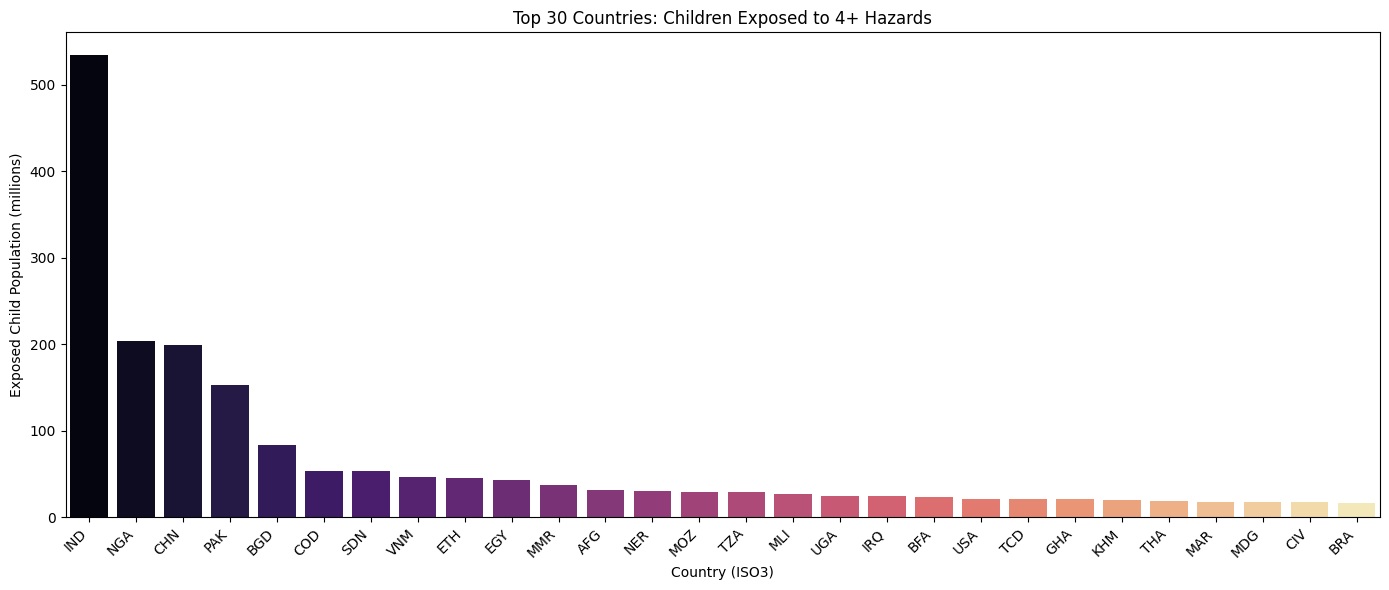

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare top 30 countries
plot_df = (
    ccri_json[['ISO3', 'exposed_to_4plus_hazards']]
    .copy()
    .dropna()
    .sort_values('exposed_to_4plus_hazards', ascending=False)
    .head(30)
)

# Convert values to millions
plot_df['exposed_to_4plus_hazards_million'] = plot_df['exposed_to_4plus_hazards'] / 1_000_000

plt.figure(figsize=(14, 6))
sns.barplot(
    data=plot_df,
    x='ISO3',
    y='exposed_to_4plus_hazards_million',
    hue='ISO3',
    palette='magma',
    legend=False
)

plt.xticks(rotation=45, ha='right')
plt.title('Top 30 Countries: Children Exposed to 4+ Hazards')
plt.ylabel('Exposed Child Population (millions)')
plt.xlabel('Country (ISO3)')
plt.tight_layout()
plt.show()



In [17]:
print(region_summary)

                            Region    ge1_topics    ge3_topics    ge4_topics  \
0            East Asia and Pacific  4.860569e+08  3.525524e+08  2.127192e+08   
1      Eastern and Southern Africa  2.815191e+08  2.604082e+08  1.822056e+08   
2          Europe and Central Asia  7.467144e+07  5.345061e+07  2.071039e+07   
3  Latin America and the Caribbean  1.863318e+08  1.165739e+08  6.004697e+07   
4     Middle East and North Africa  2.626388e+08  2.369510e+08  1.810773e+08   
5                       South Asia  6.338712e+08  6.122570e+08  5.198835e+08   
6          West and Central Africa  3.051436e+08  2.951218e+08  2.563368e+08   

     ge5_topics     ge8_topics    ge6_topics    ge7_topics  ge10_topics  \
0  9.700789e+07  789221.952531  3.482574e+07  7.374499e+06   123.868512   
1  5.456536e+07   85202.850592  1.645264e+07  2.990869e+06    15.678416   
2  4.412522e+06     818.542699  3.870913e+05  2.747502e+04     0.000000   
3  2.145959e+07    9505.256889  4.323223e+06  4.717845e+05 

In [18]:
# Compute totals for all numeric columns
totals = region_summary.drop(columns='Region').sum()

# Create a total row
df_total_row = pd.DataFrame([{'Region': 'Total', **totals.to_dict()}])

# Append to the summary DataFrame
df_summary_by_region = pd.concat([region_summary, df_total_row], ignore_index=True)

In [26]:
numeric_cols = df_summary_by_region.select_dtypes(include=['number']).columns
df_summary_by_region[numeric_cols] = df_summary_by_region[numeric_cols] / 1_000_000
df_summary_by_region[numeric_cols] = df_summary_by_region[numeric_cols].round(2)


In [27]:
df_summary_by_region

,Region,ge1_topics,ge3_topics,ge4_topics,ge5_topics,ge8_topics,ge6_topics,ge7_topics,ge10_topics,ge9_topics,ge2_topics,exposed_to_4plus_hazards
0,East Asia and Pacific,486.06,352.55,212.72,97.01,0.79,34.83,7.37,0.0,0.03,457.33,352.75
1,Eastern and Southern Africa,281.52,260.41,182.21,54.57,0.09,16.45,2.99,0.0,0.00,279.49,256.30
2,Europe and Central Asia,74.67,53.45,20.71,4.41,0.00,0.39,0.03,0.0,0.00,71.19,25.54
3,Latin America and the Caribbean,186.33,116.57,60.05,21.46,0.01,4.32,0.47,0.0,0.00,169.39,86.31
4,Middle East and North Africa,262.64,236.95,181.08,93.31,0.10,21.05,2.57,0.0,0.00,257.05,298.12
5,South Asia,633.87,612.26,519.88,242.30,0.05,41.60,2.02,0.0,0.00,628.66,805.84
6,West and Central Africa,305.14,295.12,256.34,178.71,0.03,33.20,1.71,0.0,0.00,303.86,470.00
7,Total,2230.23,1927.31,1432.98,691.76,1.08,151.84,17.17,0.0,0.03,2166.98,2294.86


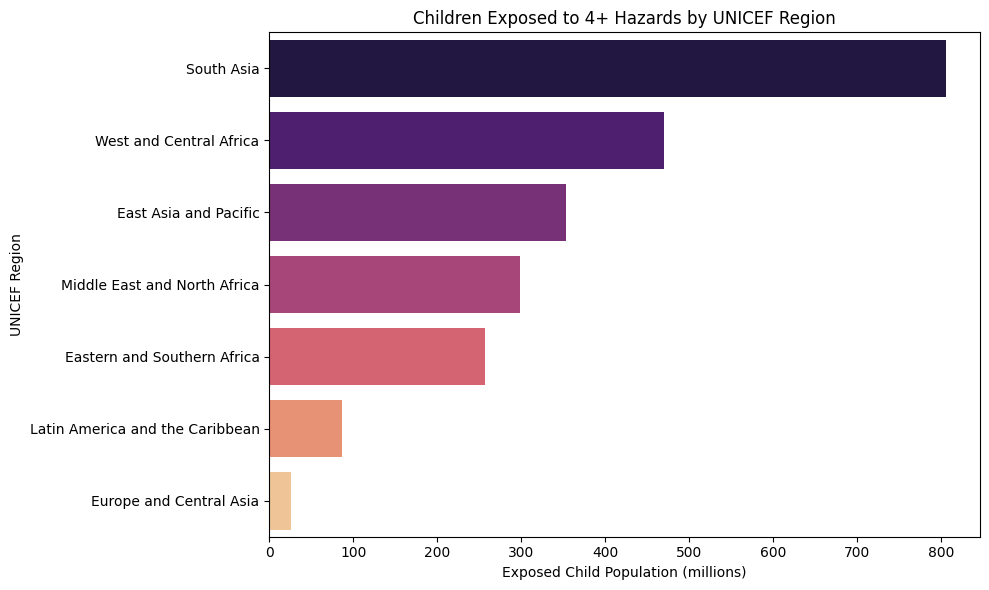

In [20]:
# Convert exposed_to_4plus_hazards to millions
region_summary["exposed_to_4plus_hazards_million"] = region_summary["exposed_to_4plus_hazards"] / 1_000_000

# Sort the data by the new column in descending order
region_summary_sorted = region_summary.sort_values(by="exposed_to_4plus_hazards_million", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=region_summary_sorted,
    y="Region",
    x="exposed_to_4plus_hazards_million",
    hue="Region",
    palette="magma",
    dodge=False,
    legend=False
)

plt.title("Children Exposed to 4+ Hazards by UNICEF Region")
plt.xlabel("Exposed Child Population (millions)")
plt.ylabel("UNICEF Region")
plt.tight_layout()
plt.show()

In [21]:
plot_df

,ISO3,exposed_to_4plus_hazards,exposed_to_4plus_hazards_million
268,IND,5.337405e+08,533.740547
265,NGA,2.034541e+08,203.454067
54,CHN,1.993041e+08,199.304093
159,PAK,1.531877e+08,153.187713
20,BGD,8.355342e+07,83.553415
257,COD,5.307307e+07,53.073070
284,SDN,5.266444e+07,52.664441
228,SDN,5.266444e+07,52.664441
216,VNM,4.625068e+07,46.250684
75,ETH,4.480944e+07,44.809435
